In [3]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from time import strftime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Preprocesamiento de Datos

In [5]:
data_dir = "./CMAPSSData"
print("data_dir:", data_dir)
assert os.path.exists(data_dir), f"data_dir not found: {data_dir}"

# common column names used by C-MAPSS
COL_NAMES = (['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] +
             [f'sensor_{i+1}' for i in range(21)])

def discover_files(data_dir):
    """
    Return dict mapping FD ids ('FD001',...) to dicts with keys possibly 'train','test','rul'.
    This version is tolerant to filename variations and case.
    """
    mapping = {}
    for path in glob.glob(os.path.join(data_dir, "*")):
        name = os.path.basename(path).upper()
        # detect FD id present in filename
        for fd in ['FD001','FD002','FD003','FD004']:
            if fd in name:
                if fd not in mapping:
                    mapping[fd] = {}
                if 'TRAIN' in name:
                    mapping[fd]['train'] = path
                if 'TEST' in name:
                    mapping[fd]['test'] = path
                if 'RUL' in name or name.startswith('RUL_') or 'RUL' in name:
                    mapping[fd]['rul'] = path
                # also accept files named like 'train_FD001.txt' etc.
                # note: we allow multiple matches; last one wins (fine for typical datasets)
    return mapping

def load_cmapss_pair(train_path, test_path):
    """Load a single FD dataset duo"""
    train = pd.read_csv(train_path, sep='\s+', header=None, names=COL_NAMES)

    test = pd.read_csv(test_path, sep='\s+', header=None, names=COL_NAMES)

    train[['unit','cycle']] = train[['unit','cycle']].astype(int)
    test[['unit','cycle']] = test[['unit','cycle']].astype(int)
    return train.reset_index(drop=True), test.reset_index(drop=True)

# discover dataset files
mapping = discover_files(data_dir)
print("Discovered dataset keys and file types:")
for k,v in mapping.items():
    print(k, v.keys())

# --- Choose dataset FDID to run ---
FDID = 'FD001'

# If chosen FDID doesn't have train+test, pick the first available FD that has both
if FDID not in mapping or 'train' not in mapping[FDID] or 'test' not in mapping[FDID]:
    print(f"Requested {FDID} is missing train/test. Searching for first FD with both train and test...")
    chosen = None
    for fd, files in mapping.items():
        if 'train' in files and 'test' in files:
            chosen = fd
            break
    if chosen is None:
        raise FileNotFoundError(f"No FD dataset with both train and test found in {data_dir}. Mapping: {mapping}")
    print(f"Switching to available dataset: {chosen}")
    FDID = chosen

train_path = mapping[FDID]['train']
test_path  = mapping[FDID]['test']

print("Using:", train_path, test_path)
train_df, test_df = load_cmapss_pair(train_path, test_path)
print(f"Loaded {FDID}: train rows={len(train_df)} (units={train_df['unit'].nunique()}), test rows={len(test_df)} (units={test_df['unit'].nunique()})")

data_dir: ./CMAPSSData
Discovered dataset keys and file types:
FD001 dict_keys(['train', 'rul', 'test'])
FD003 dict_keys(['train', 'rul', 'test'])
FD004 dict_keys(['rul', 'train', 'test'])
FD002 dict_keys(['train', 'rul', 'test'])
Using: ./CMAPSSData/train_FD001.txt ./CMAPSSData/test_FD001.txt
Loaded FD001: train rows=20631 (units=100), test rows=13096 (units=100)


In [6]:
train_df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit          20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [8]:
train_df.describe(include='all')

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.3,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,0.885092,0.070985,22.082880,0.0,0.267087,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.3,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.3,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.3,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.3,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.3,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Se puede notar que op_setting_3, sensor_1, sensor_10, sensor_18 y sensor_19 siempre se mantiene constante, por lo que no aporta ninguna información

In [9]:
# Si se usa FD003, sensor 10 si es importante
train_df.drop(['op_setting_3', 'sensor_1', 'sensor_18', 'sensor_19'], axis=1, inplace=True)
units = train_df['unit'].nunique()

In [10]:
train_df = train_df.groupby('unit').apply(lambda x: x.head(int(len(x) * 0.4)))
train_df.reset_index(drop=True, inplace=True)

In [11]:
# Seleccionamos las características para el modelo (unit y cycle no afectan)
features = [col for col in train_df.columns if col not in ['unit', 'cycle']]
X = train_df[features].values
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [12]:
X_train_split = int(0.8 * len(X_scaled))
X_train_data = X_scaled[:X_train_split]
X_val_data = X_scaled[X_train_split:]

In [13]:
X_train_data

array([[-0.31639743, -1.3557371 , -1.5664631 , ..., -0.2946605 ,
         1.0526402 ,  0.8288917 ],
       [ 0.8868061 , -1.0165861 , -0.68185097, ..., -0.2946605 ,
         0.591375  ,  0.88755035],
       [-1.9823714 ,  1.0183198 , -0.14572243, ..., -2.0470533 ,
         0.20698732, -0.12494886],
       ...,
       [ 1.1181914 ,  1.0183198 , -0.36017385, ..., -1.1708568 ,
         0.20698732, -0.05608871],
       [ 0.51658964, -1.3557371 , -0.7890767 , ..., -2.0470533 ,
         0.9757626 ,  1.0571504 ],
       [ 1.0719143 , -0.33828413, -0.4137867 , ..., -0.2946605 ,
         0.3607424 ,  0.9984917 ]], dtype=float32)

## Gaussian Mixture Prior

El modelo asume que la distribución de los datos sucede por varias distribuciones Gaussianas. Por ejemplo, se puede asumir que una razón de por qué la distribución es resultado de varias distribuciones Gaussianas es porque diferentes motores tienen diferentes modos de operación. El número de distribuciones debe ser establecido de antemano y puede ser un hiperparámetro.

In [14]:
class GaussianMixturePrior(layers.Layer):
    """
    Mezcla Gaussiana para el vector latente.
    """
    
    def __init__(self, latent_dim, n_components=3, **kwargs):
        super(GaussianMixturePrior, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.n_components = n_components
    
    def build(self, input_shape):
        # Mixture weights (logits)
        self.mixture_logits = self.add_weight(
            name='mixture_logits',
            shape=(self.n_components,),
            initializer='zeros',
            trainable=True
        )
        
        # Mixture means
        self.mixture_means = self.add_weight(
            name='mixture_means',
            shape=(self.n_components, self.latent_dim),
            initializer='zeros',
            trainable=True
        )
        
        # Mixture log variances
        self.mixture_log_vars = self.add_weight(
            name='mixture_log_vars',
            shape=(self.n_components, self.latent_dim),
            initializer='zeros',
            trainable=True
        )
    
    def call(self, z):
        """
        Compute log probability of z under the mixture prior.
        
        Args:
            z: Latent samples [batch_size, latent_dim]
        
        Returns:
            log_prob: Log probability under the mixture [batch_size]
        """
        # Mixture weights
        mixture_weights = tf.nn.softmax(self.mixture_logits)  # [n_components]
        
        # Expand dimensions for broadcasting
        z_expanded = tf.expand_dims(z, 1)  # [batch_size, 1, latent_dim]
        means = tf.expand_dims(self.mixture_means, 0)  # [1, n_components, latent_dim]
        log_vars = tf.expand_dims(self.mixture_log_vars, 0)  # [1, n_components, latent_dim]
        
        # Compute log probabilities for each component
        # log N(z; mu, sigma^2) = -0.5 * [log(2*pi) + log(sigma^2) + (z-mu)^2/sigma^2]
        log_probs_per_component = -0.5 * (
            tf.math.log(2.0 * np.pi) +
            log_vars +
            tf.square(z_expanded - means) / tf.exp(log_vars)
        )
        
        # Sum over latent dimensions
        log_probs_per_component = tf.reduce_sum(log_probs_per_component, axis=2)  # [batch_size, n_components]
        
        # Add log mixture weights
        log_mixture_weights = tf.math.log(mixture_weights + 1e-10)  # [n_components]
        log_probs_weighted = log_probs_per_component + log_mixture_weights  # [batch_size, n_components]
        
        # Log-sum-exp trick for numerical stability
        log_prob = tf.reduce_logsumexp(log_probs_weighted, axis=1)  # [batch_size]
        
        return log_prob
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'n_components': self.n_components
        })
        return config


## Modelos

In [15]:
class StandardVAE(Model):
    """
    Autoencoder Variacional (VAE) con perdida de divergencia KL.
    """
    
    def __init__(self, input_dim, n_hidden_layers=1, latent_dim=2, encoder_hidden=32, decoder_hidden=32, **kwargs):
        super(StandardVAE, self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = keras.Sequential(name="encoder")
        self.encoder.add(layers.Input(shape=(input_dim,)))
        
        for i in range(n_hidden_layers):
            # Gradually reduce size: 64 -> 32 -> 16 (for example)
            layer_size = hidden_size // (2 ** i)
            self.encoder.add(layers.Dense(layer_size, activation='relu', 
                                           name=f"encoder_hidden_{i}"))
        
        self.encoder.add(layers.Dense(latent_dim * 2, name='encoder_output'))  # Fixed parenthesis
        
        # Decoder: mirror the encoder (expand gradually)
        self.decoder = keras.Sequential(name='decoder')
        self.decoder.add(layers.Input(shape=(latent_dim,)))
        
        for i in range(n_hidden_layers - 1, -1, -1):  # Fixed: step=-1
            layer_size = hidden_size // (2 ** i)
            self.decoder.add(layers.Dense(layer_size, activation='relu',
                                           name=f"decoder_hidden_{i}"))
        
        self.decoder.add(layers.Dense(input_dim, name='decoder_output'))
        
        # Metrics
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.recon_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
    
    def encode(self, x):
        output = self.encoder(x)
        mean, log_var = tf.split(output, 2, axis=-1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * eps
    
    def decode(self, z):
        return self.decoder(z)
    
    def call(self, x, training=False):
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstruction = self.decode(z)
        return reconstruction
    
    @tf.function
    def train_step(self, data):
        x = data
        
        with tf.GradientTape() as tape:
            # Encode
            mean, log_var = self.encode(x)
            z = self.reparameterize(mean, log_var)
            
            # Decode
            reconstruction = self.decode(z)
            
            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=1)
            )
            
            # KL divergence loss (to standard normal prior)
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
            )
            
            # Total loss
            total_loss = recon_loss + kl_loss
        
        # Compute and apply gradients
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            'loss': total_loss,
            'reconstruction_loss': recon_loss,
            'kl_loss': kl_loss
        }
    
    @tf.function
    def test_step(self, data):
        x = data
        
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstruction = self.decode(z)
        
        recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(x - reconstruction), axis=1)
        )
        
        self.recon_loss_tracker.update_state(recon_loss)
        
        return {'loss': recon_loss}
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]
    
    def get_reconstruction_error(self, x):
        mean, _ = self.encode(x)
        reconstruction = self.decode(mean)
        errors = tf.reduce_sum(tf.square(x - reconstruction), axis=1)
        return errors.numpy()


In [16]:
class FisherAutoencoder(Model):
    """
    Autoencoder Fisher
    
    con función de pérdida
    L = (1/2L) * sum[||∇z log q(z|x) - ∇z log p(z) - ∇z log p(x|z)||^2]
        + (1/2) * ||x - f(z)||^2
        + (1/2) * ||∇x log q(z|x)||^2
    """
    
    def __init__(self, input_dim, latent_dim=2, n_components=3, 
                 n_hidden_layers=1, hidden_size=32, **kwargs):
        super(FisherAutoencoder, self).__init__(**kwargs)
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_components = n_components
        
        self.encoder = keras.Sequential(name="encoder")
        self.encoder.add(layers.Input(shape=(input_dim,)))
        
        for i in range(n_hidden_layers):
            # Gradually reduce size: 64 -> 32 -> 16 (for example)
            layer_size = hidden_size // (2 ** i)
            self.encoder.add(layers.Dense(layer_size, activation='relu', 
                                           name=f"encoder_hidden_{i}"))
        
        self.encoder.add(layers.Dense(latent_dim * 2, name='encoder_output'))  # Fixed parenthesis
        
        # Decoder: mirror the encoder (expand gradually)
        self.decoder = keras.Sequential(name='decoder')
        self.decoder.add(layers.Input(shape=(latent_dim,)))
        
        for i in range(n_hidden_layers - 1, -1, -1):  # Fixed: step=-1
            layer_size = hidden_size // (2 ** i)
            self.decoder.add(layers.Dense(layer_size, activation='relu',
                                           name=f"decoder_hidden_{i}"))
        
        self.decoder.add(layers.Dense(input_dim, name='decoder_output'))  # Fixed: input_dim
        
        # Prior and metrics...
        self.prior = GaussianMixturePrior(latent_dim, n_components)
        
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.fisher_div_tracker = keras.metrics.Mean(name='fisher_divergence')
        self.recon_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.stability_tracker = keras.metrics.Mean(name='stability_loss')
    
    def encode(self, x):
        """Encode input to latent distribution parameters."""
        output = self.encoder(x)
        mean, log_var = tf.split(output, 2, axis=-1)
        return mean, log_var
    
    def reparameterize(self, mean, log_var):
        """Reparameterization trick: z = mu + sigma * epsilon."""
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * eps
    
    def decode(self, z):
        """Decode latent vector to reconstruction."""
        return self.decoder(z)
    
    def call(self, x, training=False):
        """Forward pass."""
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstruction = self.decode(z)
        return reconstruction
    
    @tf.function
    def train_step(self, data):
        """
        Custom training step implementing the Fisher divergence loss.
        """
        x = data
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            
            # Encode
            mean, log_var = self.encode(x)
            
            # Sample from posterior using reparameterization
            z = self.reparameterize(mean, log_var)
            tape.watch(z)
            
            # Decode
            reconstruction = self.decode(z)
            
            # ===================================================================
            # Loss Component 1: Fisher Divergence Term
            # ||∇z log q(z|x) - ∇z log p(z) - ∇z log p(x|z)||^2
            # ===================================================================
            
            # Compute log q(z|x) - log probability under approximate posterior
            log_q_z_given_x = -0.5 * tf.reduce_sum(
                tf.math.log(2.0 * np.pi) + log_var + tf.square(z - mean) / tf.exp(log_var),
                axis=1
            )
            
            # Gradient of log q(z|x) with respect to z
            grad_log_q = tape.gradient(log_q_z_given_x, z)
            
            # Compute log p(z) - log probability under mixture prior
            log_p_z = self.prior(z)
            
            # Gradient of log p(z) with respect to z
            grad_log_prior = tape.gradient(log_p_z, z)
            
            # Compute log p(x|z) assuming Gaussian likelihood with unit variance
            log_p_x_given_z = -0.5 * tf.reduce_sum(
                tf.square(x - reconstruction),
                axis=1
            )
            
            # Gradient of log p(x|z) with respect to z
            grad_log_likelihood = tape.gradient(log_p_x_given_z, z)
            
            # Fisher divergence term
            fisher_div = 0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(grad_log_q - grad_log_prior - grad_log_likelihood),
                    axis=1
                )
            )
            
            # ===================================================================
            # Loss Component 2: Reconstruction Error
            # (1/2) * ||x - f(z)||^2
            # ===================================================================
            
            recon_loss = 0.5 * tf.reduce_mean(
                tf.reduce_sum(tf.square(x - reconstruction), axis=1)
            )
            
            # ===================================================================
            # Loss Component 3: Stability Control
            # (1/2) * ||∇x log q(z|x)||^2
            # ===================================================================
            
            # Gradient of log q(z|x) with respect to x
            grad_x_log_q = tape.gradient(log_q_z_given_x, x)
            
            stability_loss = 0.5 * tf.reduce_mean(
                tf.reduce_sum(tf.square(grad_x_log_q), axis=1)
            )
            
            # ===================================================================
            # Total Loss
            # ===================================================================
            
            total_loss = fisher_div + recon_loss + stability_loss
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.fisher_div_tracker.update_state(fisher_div)
        self.recon_loss_tracker.update_state(recon_loss)
        self.stability_tracker.update_state(stability_loss)
        
        return {
            'loss': total_loss, 
            'reconstruction_loss': recon_loss,
            'fisher_divergence': fisher_div,
            'stability_loss': stability_loss
        }
    
    @tf.function
    def test_step(self, data):
        """Validation step."""
        x = data
        
        # Encode
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        
        # Decode
        reconstruction = self.decode(z)
        
        # Reconstruction error
        recon_loss = 0.5 * tf.reduce_mean(
            tf.reduce_sum(tf.square(x - reconstruction), axis=1)
        )
        
        # Update metrics
        self.recon_loss_tracker.update_state(recon_loss)
        
        return {'loss': recon_loss}
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.fisher_div_tracker,
            self.recon_loss_tracker,
            self.stability_tracker
        ]
    
    def get_reconstruction_error(self, x):
        """
        Calcula valor de reconstrucción
        """
        mean, _ = self.encode(x)
        reconstruction = self.decode(mean)  # Use mean of latent distribution
        errors = tf.reduce_sum(tf.square(x - reconstruction), axis=1)
        return errors.numpy()

In [17]:
def create_run_logdir(root_logdir="logs"):
    run_id = datetime.now().strftime("run_%Y%m%d_%H%M%S")
    return Path(root_logdir) / run_id
run_logdir = create_run_logdir()

## Entrenamiento

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train_data).batch(16)
validation_data = tf.data.Dataset.from_tensor_slices(X_val_data).batch(16)

2025-11-30 15:01:46.665494: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-11-30 15:01:46.665570: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-11-30 15:01:46.665588: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.72 GB
2025-11-30 15:01:46.665688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 15:01:46.665733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Fine Tuning

In [22]:
import keras_tuner as kt

def build_model(hp):
    # Define hyperparameters
    latent_dim = hp.Int("latent_dim", min_value=2, max_value=3)
    n_components = hp.Int("n_components", min_value=2, max_value=5)
    hidden_size = hp.Int("hidden_size", min_value=32, max_value=128, step=32)
    n_hidden_layers = hp.Int("n_hidden_layers", min_value=1, max_value=3)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    
    # Build model with hyperparameters
    model = FisherAutoencoder(
        n_hidden_layers=n_hidden_layers,
        input_dim=X_train_data.shape[1],
        latent_dim=latent_dim,  # Use the hp value!
        n_components=n_components,
        hidden_size=hidden_size
    )
    
    # Compile with Adam optimizer (SGD doesn't work well for autoencoders)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
    
    return model


In [23]:
random_search_tuner = kt.RandomSearch(
    build_model, 
    objective="val_loss",  # Changed from val_accuracy
    max_trials=10,
    overwrite=True,
    directory="anomaly_detection", 
    project_name="fisher_ae_tuning", 
    seed=42
)

In [24]:
random_search_tuner.search(
    train_dataset,
    epochs=30,
    validation_data=validation_data,
    verbose=1
)

Trial 10 Complete [00h 01m 59s]
val_loss: 5.261476039886475

Best val_loss So Far: 4.707704067230225
Total elapsed time: 00h 21m 00s


In [29]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[1]
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[2].values

{'latent_dim': 2,
 'n_components': 4,
 'hidden_size': 32,
 'n_hidden_layers': 2,
 'learning_rate': 0.0003069273045576997}

### Fisher

In [16]:
model = FisherAutoencoder(
        input_dim=X_train_data.shape[1],
        latent_dim=3,
        n_components=2,
        encoder_hidden=32,
        decoder_hidden=32
    )

In [17]:
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001))
run_logdir = create_run_logdir()

In [18]:
callbacks = [
        keras.callbacks.TensorBoard(log_dir=str(run_logdir), histogram_freq=1),
        keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
    ]

In [19]:
history = model.fit(
        train_dataset,
        epochs=40,
        validation_data=validation_data,
        callbacks=callbacks
    )

Epoch 1/40


2025-11-30 13:05:37.458061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


411/411 [==============================] - 5s 10ms/step - loss: 8.9448 - reconstruction_loss: 7.2103 - fisher_divergence: 0.6548 - stability_loss: 0.0898 - val_loss: 5.8898
Epoch 2/40
411/411 [==============================] - 4s 10ms/step - loss: 6.3452 - reconstruction_loss: 6.5185 - fisher_divergence: 0.6545 - stability_loss: 0.0567 - val_loss: 5.5546
Epoch 3/40
411/411 [==============================] - 4s 10ms/step - loss: 5.9131 - reconstruction_loss: 5.2620 - fisher_divergence: 0.4992 - stability_loss: 0.0375 - val_loss: 6.2073
Epoch 4/40
411/411 [==============================] - 4s 10ms/step - loss: 5.6965 - reconstruction_loss: 5.3929 - fisher_divergence: 0.6217 - stability_loss: 0.0218 - val_loss: 5.3774
Epoch 5/40
411/411 [==============================] - 4s 10ms/step - loss: 5.7015 - reconstruction_loss: 5.6112 - fisher_divergence: 0.7402 - stability_loss: 0.0229 - val_loss: 5.5357
Epoch 6/40
411/411 [==============================] - 4s 10ms/step - loss: 5.7923 - reconst

### VAE

In [47]:
vae = StandardVAE(X_train_data.shape[1], latent_dim=2)
vae.compile(optimizer=keras.optimizers.legacy.Adam(0.0001))

In [48]:
vae_logdir = create_run_logdir("logs/vae")
vae_callbacks = [
    keras.callbacks.TensorBoard(log_dir=str(vae_logdir)),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

In [49]:
vae_history = vae.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_data,
    callbacks=vae_callbacks,
    verbose=1
)

Epoch 1/40
411/411 [==============================] - 2s 5ms/step - loss: 21.4621 - reconstruction_loss: 24.2174 - kl_loss: 1.2650 - val_loss: 13.8888
Epoch 2/40
411/411 [==============================] - 2s 4ms/step - loss: 17.6675 - reconstruction_loss: 21.2037 - kl_loss: 1.4399 - val_loss: 12.1015
Epoch 3/40
411/411 [==============================] - 2s 4ms/step - loss: 15.3640 - reconstruction_loss: 15.7594 - kl_loss: 2.0145 - val_loss: 12.1263
Epoch 4/40
411/411 [==============================] - 2s 4ms/step - loss: 14.1311 - reconstruction_loss: 16.3000 - kl_loss: 2.0043 - val_loss: 11.6625
Epoch 5/40
411/411 [==============================] - 2s 4ms/step - loss: 13.5796 - reconstruction_loss: 14.4190 - kl_loss: 1.9012 - val_loss: 12.2107
Epoch 6/40
411/411 [==============================] - 2s 4ms/step - loss: 13.3830 - reconstruction_loss: 11.5310 - kl_loss: 1.8725 - val_loss: 11.1883
Epoch 7/40
411/411 [==============================] - 2s 4ms/step - loss: 13.1820 - reconstruc

## Evaluación

In [20]:
def detect_anomalies(model, X, threshold_percentile=90):
    """
    Detect anomalies using reconstruction error.
    
    Args:
        model: Trained Fisher Autoencoder
        X: Data to test [n_samples, n_features]
        threshold_percentile: Percentile for anomaly threshold
    
    Returns:
        errors: Reconstruction errors
        threshold: Anomaly threshold
        is_anomaly: Boolean array indicating anomalies
    """
    errors = model.get_reconstruction_error(X)
    threshold = np.percentile(errors, threshold_percentile)
    is_anomaly = errors > threshold
    
    return errors, threshold, is_anomaly

In [21]:
def visualize_latent_space(model, X, y=None, save_path=None):
    """
    Visualize the latent space (works for 2D or 3D latent spaces).
    
    Args:
        model: Trained Fisher Autoencoder
        X: Data samples
        y: Labels (optional, for coloring)
        save_path: Path to save figure (optional)
    """
    mean, _ = model.encode(X)
    z = mean.numpy()
    
    if model.latent_dim == 2:
        plt.figure(figsize=(10, 8))
        
        if y is not None:
            scatter = plt.scatter(z[:, 0], z[:, 1], c=y, cmap='coolwarm', alpha=0.6)
            plt.colorbar(scatter, label='Anomaly Score')
        else:
            plt.scatter(z[:, 0], z[:, 1], alpha=0.6)
        
        plt.xlabel('Latent Variable 1')
        plt.ylabel('Latent Variable 2')
        plt.title('Latent Space Distribution')
        plt.grid(True, alpha=0.3)
        
    elif model.latent_dim == 3:
        fig = plt.figure(figsize=(12, 9))
        ax = fig.add_subplot(111, projection='3d')
        
        if y is not None:
            scatter = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=y, cmap='coolwarm', alpha=0.6)
            plt.colorbar(scatter, label='Anomaly Score')
        else:
            ax.scatter(z[:, 0], z[:, 1], z[:, 2], alpha=0.6)
        
        ax.set_xlabel('Latent Variable 1')
        ax.set_ylabel('Latent Variable 2')
        ax.set_zlabel('Latent Variable 3')
        ax.set_title('Latent Space Distribution')
    
    else:
        print(f"Visualization not supported for {model.latent_dim}D latent space")
        return
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [22]:
def plot_reconstruction_errors(errors, threshold, is_anomaly, save_path=None):
    """
    Plot reconstruction errors and anomaly threshold.
    
    Args:
        errors: Reconstruction errors
        threshold: Anomaly threshold
        is_anomaly: Boolean array indicating anomalies
        save_path: Path to save figure (optional)
    """
    plt.figure(figsize=(14, 6))
    
    plt.plot(errors, label='Reconstruction Error', alpha=0.7)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
    
    # Highlight anomalies
    anomaly_indices = np.where(is_anomaly)[0]
    plt.scatter(anomaly_indices, errors[anomaly_indices], color='red', 
                label='Anomalies', zorder=5, s=30)
    
    plt.xlabel('Data Point (Record)')
    plt.ylabel('Reconstruction Error')
    plt.title('Anomaly Detection using Reconstruction Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

### Fisher

In [23]:
errors_train, threshold, is_anomaly_train = detect_anomalies(
    model, X_train_data, 90
)

n_anomalies = np.sum(is_anomaly_train)
print(f"  Threshold: {threshold:.4f}")
print(f"  Anomalies detected: {n_anomalies}/{len(X_train_data)} ({100*n_anomalies/len(X_train_data):.2f}%)")

  Threshold: 24.4960
  Anomalies detected: 658/6572 (10.01%)


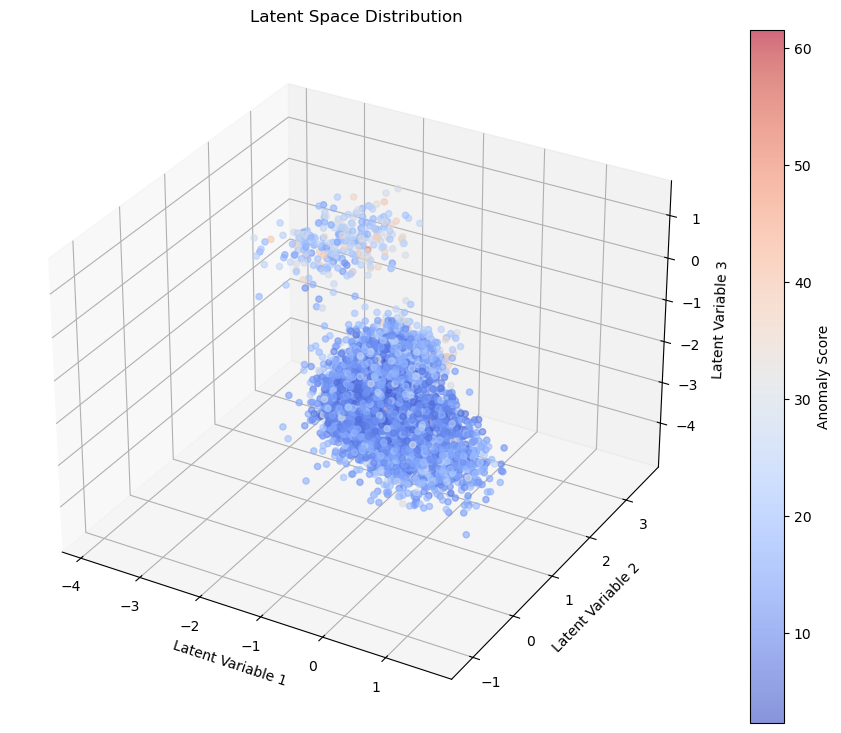

In [24]:
# Visualize latent space
visualize_latent_space(
    model, X_train_data, 
    y=errors_train,
    save_path='latent_space.png'
)

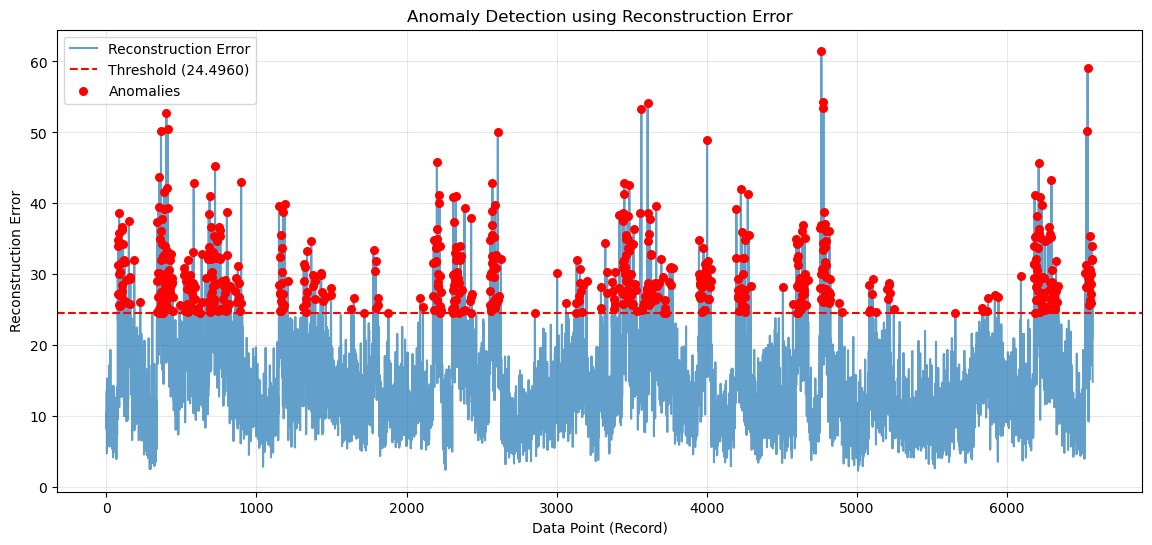

In [25]:
plot_reconstruction_errors(
    errors_train, threshold, is_anomaly_train,
    save_path='reconstruction_errors.png'
)

### VAE

In [51]:
vae_errors_train, vae_threshold, vae_is_anomaly_train = detect_anomalies(
    vae, X_train_data, 90
)

vae_n_anomalies = np.sum(vae_is_anomaly_train)
print(f"  Threshold: {threshold:.4f}")
print(f"  Anomalies detected: {vae_n_anomalies}/{len(X_train_data)} ({100*vae_n_anomalies/len(X_train_data):.2f}%)")

  Threshold: 24.4960
  Anomalies detected: 658/6572 (10.01%)


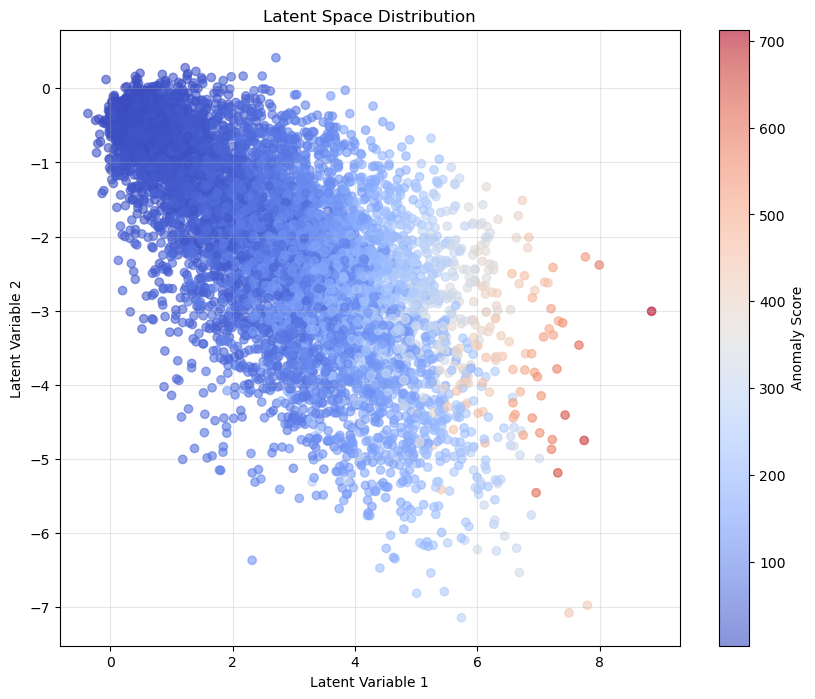

In [52]:
visualize_latent_space(
    vae, X_train_data, 
    y=vae_errors_train,
    save_path='vae_latent_space.png'
)

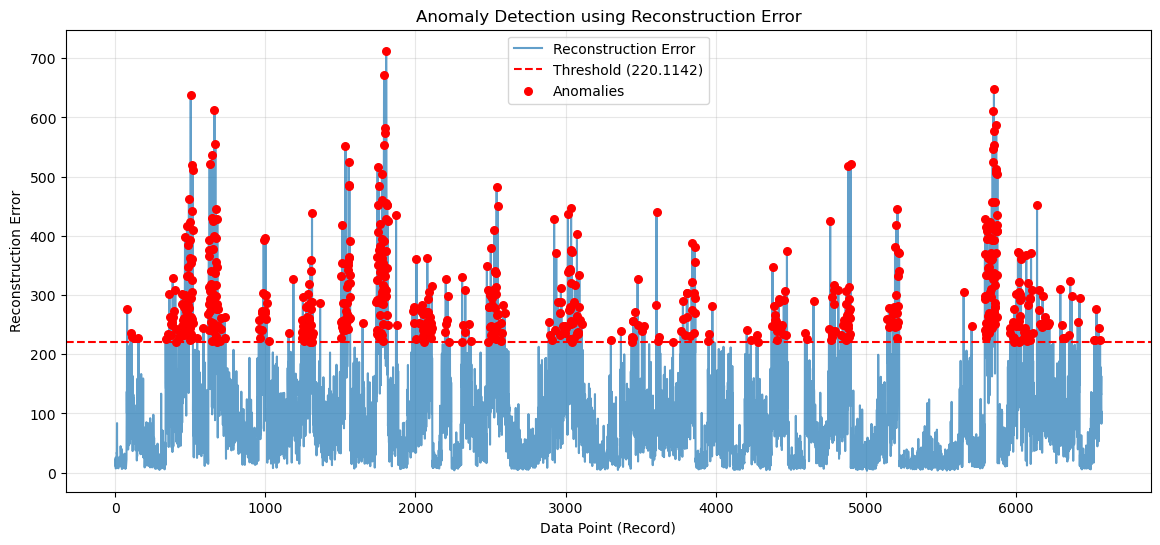

In [53]:
plot_reconstruction_errors(
    vae_errors_train, vae_threshold, vae_is_anomaly_train,
    save_path='vae_reconstruction_errors.png'
)